In [1]:
import os
import ntpath

from multiprocessing import Pool

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras

import runai.ga

from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.utils.np_utils import to_categorical

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from imgaug import augmenters as iaa

import tensorflow as tf
from tensorflow.python.client import device_lib

import datetime

import cv2
import pandas as pd
import random

In [2]:
datadir = "lesson14_recording_2"
columns = [ 'center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed' ]
data = pd.read_csv( os.path.join( datadir, 'images.csv' ), names = columns )
data.head()

,center,left,right,steering,throttle,reverse,speed
0,/home/baudisch/programming/udemy/complete_self...,/home/baudisch/programming/udemy/complete_self...,/home/baudisch/programming/udemy/complete_self...,0.0,1.0,0.0,12.76234
1,/home/baudisch/programming/udemy/complete_self...,/home/baudisch/programming/udemy/complete_self...,/home/baudisch/programming/udemy/complete_self...,0.0,1.0,0.0,13.37253
2,/home/baudisch/programming/udemy/complete_self...,/home/baudisch/programming/udemy/complete_self...,/home/baudisch/programming/udemy/complete_self...,0.0,1.0,0.0,14.22138
3,/home/baudisch/programming/udemy/complete_self...,/home/baudisch/programming/udemy/complete_self...,/home/baudisch/programming/udemy/complete_self...,0.0,1.0,0.0,15.02460
4,/home/baudisch/programming/udemy/complete_self...,/home/baudisch/programming/udemy/complete_self...,/home/baudisch/programming/udemy/complete_self...,0.0,1.0,0.0,15.40608


In [3]:
def path_leaf( path ):
    head, tail = ntpath.split( path )
    return tail

data[ 'center' ] = data[ 'center' ].apply( path_leaf )
data[ 'left' ] = data[ 'left' ].apply( path_leaf )
data[ 'right' ] = data[ 'right' ].apply( path_leaf )
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2020_11_17_23_36_29_938.jpg,left_2020_11_17_23_36_29_938.jpg,right_2020_11_17_23_36_29_938.jpg,0.0,1.0,0.0,12.76234
1,center_2020_11_17_23_36_30_006.jpg,left_2020_11_17_23_36_30_006.jpg,right_2020_11_17_23_36_30_006.jpg,0.0,1.0,0.0,13.37253
2,center_2020_11_17_23_36_30_074.jpg,left_2020_11_17_23_36_30_074.jpg,right_2020_11_17_23_36_30_074.jpg,0.0,1.0,0.0,14.22138
3,center_2020_11_17_23_36_30_141.jpg,left_2020_11_17_23_36_30_141.jpg,right_2020_11_17_23_36_30_141.jpg,0.0,1.0,0.0,15.02460
4,center_2020_11_17_23_36_30_210.jpg,left_2020_11_17_23_36_30_210.jpg,right_2020_11_17_23_36_30_210.jpg,0.0,1.0,0.0,15.40608


[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


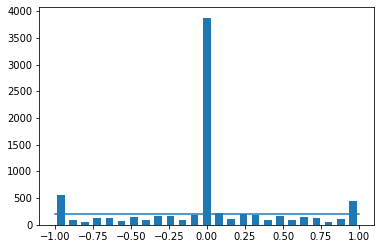

In [4]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram( data[ 'steering' ], num_bins )
center = ( bins[ : -1 ] + bins[ 1: ] ) * 0.5
print( bins )
plt.bar( center, hist, width = 0.05 )
plt.plot( ( np.min( data[ 'steering' ] ), np.max( data[ 'steering' ] ) ), ( samples_per_bin, samples_per_bin ) )

total data:  7677
removed:  4293
remaining:  3384


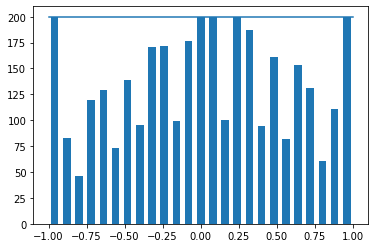

In [5]:
print( 'total data: ', len ( data ) )
remove_list = []
for j in range( num_bins ):
    list_ = []
    for i in range( len ( data[ 'steering' ] ) ):
        if data[ 'steering' ][ i ] >= bins[ j ] and data[ 'steering' ][ i ] <= bins[ j + 1 ]:
            list_.append( i )
    list_ = shuffle( list_ )
    list_ = list_[ samples_per_bin: ]
    remove_list.extend( list_ )

print( 'removed: ', len( remove_list ) )
data.drop( data.index[ remove_list ], inplace = True )
print( 'remaining: ', len( data ) )

hist, _ = np.histogram( data[ 'steering' ], ( num_bins ) )

plt.bar( center, hist, width = 0.05 )
plt.plot( ( np.min( data[ 'steering' ] ), np.max( data[ 'steering' ] ) ), ( samples_per_bin, samples_per_bin ) )

In [6]:
print( data.iloc[ 1 ] )
def load_img_steering( datadir, df ):
    image_path = []
    steering = []
    for i in range( len( data ) ):
        indexed_data = data.iloc[ i ]
        center, left, right = indexed_data[ 0 ], indexed_data[ 1 ], indexed_data[ 2 ]
        image_path.append( os.path.join( datadir, center.strip() ) )
        steering.append( float( indexed_data[ 3 ] ) )
    image_paths = np.asarray( image_path )
    steerings = np.asarray( steering )
    return image_paths, steerings

image_paths, steerings = load_img_steering( datadir + '/IMG', data )

center      center_2020_11_17_23_36_32_373.jpg
left          left_2020_11_17_23_36_32_373.jpg
right        right_2020_11_17_23_36_32_373.jpg
steering                                  0.25
throttle                                     0
reverse                                      0
speed                                  29.4233
Name: 34, dtype: object


In [7]:
def img_preprocess( img ):
    img = img[ 60:135, :, : ]
    img = cv2.cvtColor( img, cv2.COLOR_RGB2YUV )
    img = cv2.GaussianBlur( img, ( 3, 3 ), 0 )
    img = cv2.resize( img, ( 200, 66 ) )
    img = img / 255
    return img

In [8]:
def img_preprocess_load( img_path ):
    img = mpimg.imread( img_path )
    img = img_preprocess( img )
    return img

In [9]:
def zoom( img ):
    zoom = iaa.Affine( scale = ( 1.0, 1.3 ) )
    img_ret = zoom.augment_image( img )
    return img_ret

In [10]:
def pan( img ):
    pan = iaa.Affine( translate_percent = { "x": ( -0.1, 0.1 ), "y": ( -0.1, 0.1 ) } )
    img_ret = pan.augment_image( img )
    return img_ret

In [11]:
def img_rnd_brightness( img ):
    brightness = iaa.Multiply( ( 0.2, 1.2 ) )
    img_ret = brightness.augment_image( img )
    return img_ret

In [12]:
def flip( img, steering_angle ):
    img_ret = cv2.flip( img, 1 )
    return img_ret, (-steering_angle)

In [13]:
def random_augment( image, steering_angle ):
    if np.random.rand() < 0.5:
        image = zoom( image )
    if np.random.rand() < 0.5:
        image = pan( image )
    if np.random.rand() < 0.5:
        image = img_rnd_brightness( image )
    if np.random.rand() < 0.5:
        image, steering_angle = flip( image, steering_angle )
    return image, steering_angle

In [14]:
def batch_generator_train( images_list, steering_angles, batch_size ):
    #yield
    while True:
        batch_img = []
        batch_steering = []
        for i in range( batch_size ):
            idx = random.randint( 0, len( images_list ) - 1 )

            img, steering = random_augment( images_list[ idx ], steering_angles[ idx ]  )

            img = img_preprocess( img )
            batch_img.append( img )
            batch_steering.append( steering )
        yield ( np.asarray( batch_img ), np.asarray( batch_steering ) )

In [15]:
def batch_generator_valid( images_list, steering_angles, batch_size ):
    #yield
    while True:
        batch_img = []
        batch_steering = []
        for i in range( batch_size ):
            idx = random.randint( 0, len( images_list ) - 1 )

            img = images_list[ idx ]
            steering = steering_angles[ idx ]

            img = img_preprocess( img )
            batch_img.append( img )
            batch_steering.append( steering )
        yield ( np.asarray( batch_img ), np.asarray( batch_steering ) )

In [16]:
def batch_preparator( images_list, steering_angles, num_runs ):
    time_start = datetime.datetime.now()
    ######################################
    batch_img = []
    batch_steering = []
    for i in range( num_runs ):
        print ("batch_preparator: iterator ", (i+1), " / ", num_runs )
        for idx in range( len(images_list)):
            #idx = random.randint( 0, len( images_list ) - 1 )

            img, steering = random_augment( images_list[ idx ], steering_angles[ idx ]  )
            img = img_preprocess( img )
            batch_img.append( img )
            batch_steering.append( steering )
    ######################################
    time_end = datetime.datetime.now()
    time_diff = time_end - time_start
    print ("Time Diff: ", time_diff)
    ######################################
    return ( np.asarray( batch_img ), np.asarray( batch_steering ) )

Text(0.5, 1.0, 'Preprocessed Image')

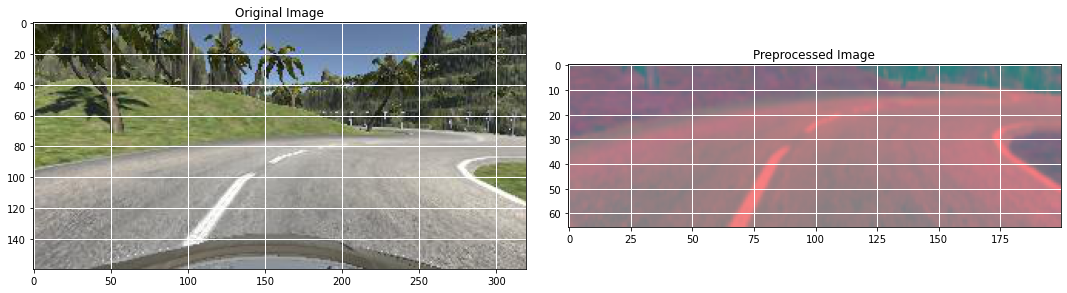

In [17]:
img_path = image_paths[ 100 ]
img_original = mpimg.imread( img_path )
img_preprocessed = img_preprocess_load( img_path )

fig, axs = plt.subplots( 1, 2, figsize = ( 15, 10 ) )
fig.tight_layout()
axs[ 0 ].imshow( img_original )
axs[ 0 ].grid( color='w', linestyle='-', linewidth = 1 )
axs[ 0 ].set_title( 'Original Image' )
axs[ 1 ].imshow( img_preprocessed )
axs[ 1 ].grid( color='w', linestyle='-', linewidth = 1 )
axs[ 1 ].set_title( 'Preprocessed Image' )

Training Samples: 2707
Valid Samples: 677
(2707, 160, 320, 3)


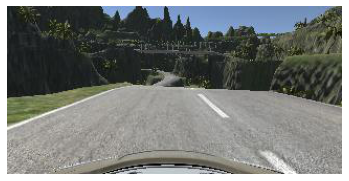

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split( image_paths, steerings, test_size = 0.2, random_state = 87 )
print( 'Training Samples: {}\nValid Samples: {}'.format( len( X_train ), len( X_valid ) ))

#images_list = np.array( list( map( mpimg.imread, image_paths ) ) )

X_train_imgs = np.array( list( map( mpimg.imread, X_train ) ) )
X_valid_imgs = np.array( list( map( mpimg.imread, X_valid ) ) )

plt.imshow( X_train_imgs[ random.randint( 0, len( X_train_imgs ) - 1 ) ] )
plt.axis( 'off' )
print( X_train_imgs.shape )

In [19]:
# version 2 of the batch preparator uses the sequential operator of IAA to accelerate the preparation
# due to the way it applies the operator, it will generate twice as many picture as the first version
# of the  batch_preparator
#
seq_noflip = iaa.Sequential([
    iaa.Sometimes(
        0.5,
        iaa.Affine( scale = ( 1.0, 1.3 ) )
    ),
    iaa.Sometimes(
        0.5,
        iaa.Affine( translate_percent = { "x": ( -0.1, 0.1 ), "y": ( -0.1, 0.1 ) } )
    ),
    iaa.Sometimes(
        0.5,
        iaa.Multiply( ( 0.2, 1.2 ) )
    )
], random_order=True) # apply augmenters in random order

seq_flip = iaa.Sequential([
    iaa.Sometimes(
        0.5,
        iaa.Affine( scale = ( 1.0, 1.3 ) )
    ),
    iaa.Sometimes(
        0.5,
        iaa.Affine( translate_percent = { "x": ( -0.1, 0.1 ), "y": ( -0.1, 0.1 ) } )
    ),
    iaa.Sometimes(
        0.5,
        iaa.Multiply( ( 0.2, 1.2 ) )
    ),
    iaa.Fliplr(1.0) # horizontally flip 50% of all images
], random_order=True) # apply augmenters in random order

def batch_preparator_2( images_list, steering_angles, num_runs ):
    time_start = datetime.datetime.now()
    ######################################

    batch_img = [ images_list[0] ]
    batch_steering = []

    for i in range( num_runs ):
        print ("batch_preparator: iterator ", (i+1), " / ", num_runs )

        time_start_i = datetime.datetime.now()
        ######################################
        img1 = seq_noflip( images = images_list )
        img2 = seq_flip( images = images_list )

        batch_img = np.concatenate( ( batch_img, img1, img2 ) )
        batch_steering = np.concatenate( ( batch_steering, steering_angles, ( -1 ) * steering_angles ) )

        ######################################
        time_end_i = datetime.datetime.now()
        time_diff_i = time_end_i - time_start_i
        print ("Time diff for this iteration: ", time_diff_i)

    batch_img = np.array( batch_img )
    print (batch_img.shape)
    batch_img = np.array( list( map( img_preprocess, batch_img ) ) )

    ######################################
    time_end = datetime.datetime.now()
    time_diff = time_end - time_start
    print ("Time Diff: ", time_diff)

    return ( np.asarray( batch_img ), np.asarray( batch_steering ) )

# X_train_imgs, y_train

def gen_batch_img( i ):
    if i & 1:
        return seq_noflip( images = X_train_imgs )
    else:
        return seq_flip( images = X_train_imgs )
def gen_batch_sta( i ):
    if i & 1:
        return y_train
    else:
        return (-1) * y_train

def batch_preparator_3( images_list, steering_angles, num_runs ):
    time_start = datetime.datetime.now()
    ######################################

    tuple1 = range( num_runs )

    with Pool(processes=4) as pool:
        time_start_i = datetime.datetime.now()
        ######################################

        # print "[0, 1, 4,..., 81]"
        batch_img = tuple( list( pool.map( gen_batch_img, tuple1 ) ) )
        ######################################
        time_end_i = datetime.datetime.now()
        time_diff_i = time_end_i - time_start_i
        print ("Time diff for batch gen: ", time_diff_i)

    batch_sta = list( map( gen_batch_sta, tuple1 ) )
    batch_img = np.concatenate( batch_img )
    batch_sta = np.concatenate( batch_sta )
    batch_img = np.array( batch_img )

    time_start_i = datetime.datetime.now()
    ######################################
    batch_img = np.array( list( map( img_preprocess, batch_img ) ) )
    ######################################
    time_end_i = datetime.datetime.now()
    time_diff_i = time_end_i - time_start_i
    print ("Time diff for preprocess: ", time_diff_i)

    ######################################
    time_end = datetime.datetime.now()
    time_diff = time_end - time_start
    print ("Time Diff: ", time_diff)

    return ( np.asarray( batch_img ), np.asarray( batch_sta ) )

Time diff for batch gen:  0:00:25.163935
Time diff for preprocess:  0:00:26.486916
Time Diff:  0:00:57.424708
(86624, 66, 200, 3)
(86624,)


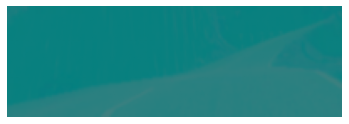

In [20]:
(X_train_pp, y_train_pp) = batch_preparator_3( X_train_imgs, y_train, 32 )
X_valid_pp = np.array( list( map( img_preprocess, X_valid_imgs ) ) )

plt.imshow( X_train_pp[ random.randint( 0, len( X_train_pp ) - 1 ) ] )
plt.axis( 'off' )
print( X_train_pp.shape )
print( y_train_pp.shape )

Text(0.5, 1.0, 'Training set')

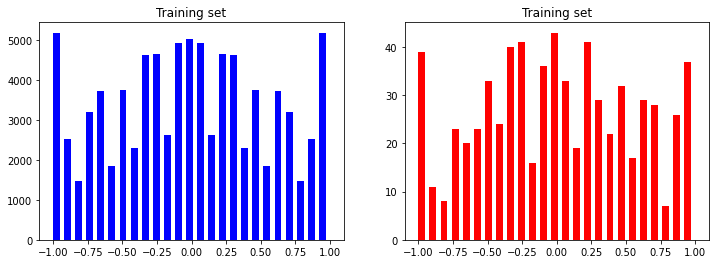

In [21]:
fig, axes = plt.subplots( 1, 2, figsize=( 12, 4 ) )
axes[ 0 ].hist( y_train_pp, bins = num_bins, width = 0.05, color = 'blue' )
axes[ 0 ].set_title('Training set')
axes[ 1 ].hist( y_valid, bins = num_bins, width = 0.05, color = 'red' )
axes[ 1 ].set_title('Training set')

In [22]:
def nvidia_model():
    model = Sequential()
    model.add( Convolution2D( 24, 5, 2, input_shape = ( 66, 200, 3 ), activation = 'elu' ) )
    model.add( Convolution2D( 36, 5, 2, activation = 'elu' ) )
    model.add( Convolution2D( 48, 5, 2, activation = 'elu' ) )
    model.add( Convolution2D( 64, 3, activation = 'elu' ) )
    model.add( Convolution2D( 64, 3, activation = 'elu' ) )
    #model.add( Dropout( 0.5 ) )

    model.add( Flatten() )
    model.add( Dense( 100, activation = 'elu' ) )
    #model.add( Dropout( 0.5 ) )

    model.add( Dense( 50, activation = 'elu' ) )
    #model.add( Dropout( 0.5 ) )

    model.add( Dense( 10, activation = 'elu' ) )
    #model.add( Dropout( 0.5 ) )

    model.add( Dense(1) )

    model.compile( Adam( lr = 1e-3 ), loss = 'mse' )
    return model

#Epoch 30/30
#217/217 [==============================] - 12s 55ms/step - loss: 0.1279 - val_loss: 0.1023

In [24]:
model = nvidia_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 100)              

In [25]:
#history = model.fit( X_train_flat, y_train_flat, epochs = 20,  validation_data = ( X_val_flat, y_val_flat), batch_size = 400, verbose = 1, shuffle = 1)
history = model.fit( X_train_pp, y_train_pp, epochs = 30, validation_data = ( X_valid_pp, y_valid ), batch_size = 400, verbose = 1, shuffle = 1 )

Epoch 1/30
217/217 [==============================] - 21s 85ms/step - loss: 0.3328 - val_loss: 0.1370
Epoch 2/30
217/217 [==============================] - 18s 82ms/step - loss: 0.1539 - val_loss: 0.1303
Epoch 3/30
217/217 [==============================] - 18s 81ms/step - loss: 0.1315 - val_loss: 0.1117
Epoch 4/30
217/217 [==============================] - 18s 81ms/step - loss: 0.1141 - val_loss: 0.1065
Epoch 5/30
217/217 [==============================] - 18s 81ms/step - loss: 0.1047 - val_loss: 0.1033
Epoch 6/30
217/217 [==============================] - 17s 80ms/step - loss: 0.0955 - val_loss: 0.1064
Epoch 7/30
217/217 [==============================] - 18s 81ms/step - loss: 0.0859 - val_loss: 0.1054
Epoch 8/30
217/217 [==============================] - 17s 79ms/step - loss: 0.0773 - val_loss: 0.1066
Epoch 9/30
217/217 [==============================] - 18s 81ms/step - loss: 0.0670 - val_loss: 0.1057
Epoch 10/30
217/217 [==============================] - 17s 80ms/step - loss: 0.058

Text(0.5, 0, 'Epoch')

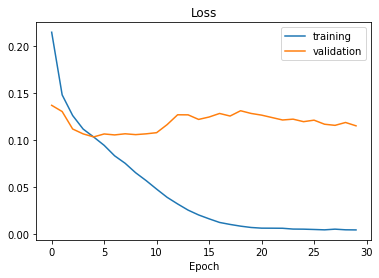

In [26]:
plt.plot( history.history[ 'loss' ] )
plt.plot( history.history[ 'val_loss' ] )
plt.legend( [ 'training', 'validation' ] )
plt.title( 'Loss' )
plt.xlabel( 'Epoch' )

In [27]:
model.save( 'model2.h5' )